In [1]:
import numpy as np

import torch
import torch.utils.data

import matplotlib.pyplot as plt

import datasets
import metaimage
import nnet
import voxgrid
import display

%load_ext autoreload
%autoreload 2

Number of training images: 217
Number of validation images: 25


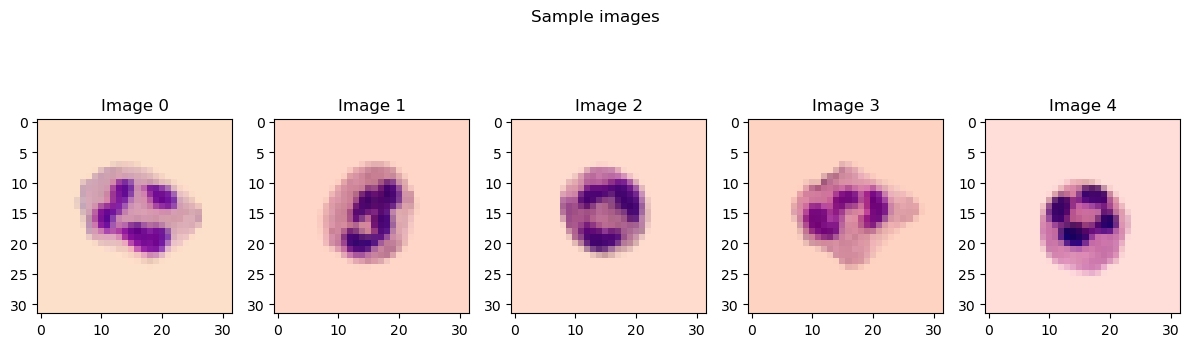

In [2]:
IMAGE_SIZE = (32, 32)
SPACE_SIZE = (32, 32, 32)

BATCH_SIZE = 50

IMG_FOLDER = "images/IsolatedNeutro/"

train_imgs, val_imgs = datasets.split_folder(IMG_FOLDER, 0.9)

print(f"Number of training images: {len(train_imgs)}")
print(f"Number of validation images: {len(val_imgs)}")

train_auto_dataset = datasets.CachedImages(IMG_FOLDER, train_imgs, train=True)
val_auto_dataset = datasets.CachedImages(IMG_FOLDER, val_imgs)

train_auto_loader = torch.utils.data.DataLoader(
    train_auto_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_auto_loader = torch.utils.data.DataLoader(val_auto_dataset, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            (f"Image {i}", metaimage.ColourImage(train_auto_dataset[i][0])) for i in range(5)
        ]
    ],
    figsize=(12, 4),
    title="Sample images",
)
display.show()

## GAN

To recover the shape, a GAN is used.

### Generator

The generator is a 3D convolutional network. The latent space is mapped linearly to a 32x4x4x4 tensor. This is then repeatedly upsampled using convolutional layer followed by a strided transpose convolution. This doubles the dimensions and halves the number of channels at each stage, to reach a 4x32x32x32 tensor. Finally, this is passed through a resnet block for refinement, and a final convolutional layer to produce a 1x32x32x32 tensor.

This tensor can then be returned, to provide a voxel representation, or a mask is created from a random angle around the cube to produce a 32x32 mask.

### Discriminator

The discriminator is a 2D resnet. This takes in a 32x32 mask, passes it through a resnet block and downsample using a strided convolution, halving the dimensions and doubling the number of channels at each stage. This is until a 4x4 mask is produced, which is then flattened and passed through a linear layer to produce a single label indicating the probability that the mask is real.

In [14]:
LATENT_SIZE = 64
BASE_CHANNELS = 16
DISCRIMINATOR_CHANNELS = 8
BACKGROUND_CHANNELS = 3
ACTIVATION = torch.nn.LeakyReLU

DISCRIMINATOR_DROPOUT = 0.1
GENERATOR_DROPOUT = 0.1

DEVICE = torch.device("cuda:0")

def create_nnets():
    discriminator = torch.nn.Sequential(
        nnet.blocks.conv.BasicConvBlock(
            in_channels=3,
            out_channels=DISCRIMINATOR_CHANNELS,
            kernel_size=7,
            stride=2,
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(DISCRIMINATOR_CHANNELS, IMAGE_SIZE[0]//2, IMAGE_SIZE[1]//2),
            out_shape=(DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0]//4, 2, 2),
            layer_factory=nnet.blocks.resnet.create_resnet_2d_factory(
                stochastic_depth_rate=DISCRIMINATOR_DROPOUT,
                activation=ACTIVATION,
                dropout=DISCRIMINATOR_DROPOUT,
            ),
            resize_factory=nnet.blocks.conv.create_strided_downsample_factory(
                activation=ACTIVATION,
                dropout=DISCRIMINATOR_DROPOUT,
            ),
            layer_factories_per_downsample=2,
        ),
        nnet.blocks.conv.ConvToLinear(
            (DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0]//4, 2, 2),
            out_dim=1,
            activation=torch.nn.Sigmoid,
        ),
    )

    voxel_generator = torch.nn.Sequential(
        nnet.blocks.conv.LinearToConv(
            in_dim=LATENT_SIZE,
            out_shape=(BASE_CHANNELS * SPACE_SIZE[0] // 2, 2, 2, 2),
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(BASE_CHANNELS * SPACE_SIZE[0] // 2, 2, 2, 2),
            out_shape=(BASE_CHANNELS, SPACE_SIZE[0], SPACE_SIZE[1], SPACE_SIZE[2]),
            layer_factory=nnet.blocks.resnet.create_resnet_3d_factory(
                activation=ACTIVATION,
                dropout=nnet.modules.AlwaysDropout(GENERATOR_DROPOUT, device=DEVICE),
            ),
            resize_factory=nnet.blocks.conv.create_upsample_block_factory(
                use_3d=True,
                activation=ACTIVATION,
                kernel_size=5,
                dropout=nnet.modules.AlwaysDropout(GENERATOR_DROPOUT, device=DEVICE),
            ),
            layer_factories_per_downsample=2,
        ),
        nnet.blocks.conv.BasicConvBlock(
            use_3d=True,
            in_channels=BASE_CHANNELS,
            out_channels=4,
            activation=torch.nn.Sigmoid,
            kernel_size=1,
            use_batch_norm=False,
        ),
        nnet.modules.VoxGridAlphaAdjust()
    )

    background_generator = torch.nn.Sequential(
        nnet.blocks.conv.LinearToConv(
            in_dim=LATENT_SIZE,
            out_shape=(BACKGROUND_CHANNELS * 64, 1, 1),
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(BACKGROUND_CHANNELS * 64, 1, 1),
            out_shape=(BACKGROUND_CHANNELS, 64, 64),
            layer_factory=nnet.blocks.resnet.create_resnet_2d_factory(
                activation=ACTIVATION,
            ),
            resize_factory=nnet.blocks.conv.create_upsample_block_factory(
                activation=ACTIVATION,
                kernel_size=3,
            ),
            total_layers=0,
        ),
        # nnet.blocks.resnet.create_resnet_block_simple(
        #     kernel_size=5,
        #     in_channels=BACKGROUND_CHANNELS,
        #     out_channels=BACKGROUND_CHANNELS,
        #     activation=ACTIVATION, 
        # ),
        nnet.blocks.conv.BasicConvBlock(
            in_channels=BACKGROUND_CHANNELS,
            out_channels=3,
            activation=torch.nn.Sigmoid,
            kernel_size=1,
            use_batch_norm=False,
        ),
        nnet.modules.RandomPatch(IMAGE_SIZE)
    )
    
    mask_generator = nnet.generators.MaskGenerator(
        model_gen = voxel_generator,
        device = DEVICE,
        background_gen=background_generator,
        # foreground_gen=foreground_generator,
    )

    return voxel_generator, mask_generator, discriminator, background_generator

vox_gen, mask_gen, discriminator, background_gen = create_nnets()

background_trainer = nnet.training.GANTrainer(
    background_gen,
    discriminator,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

gan_trainer = nnet.training.GANTrainer(
    mask_gen,
    discriminator,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/neutro_gan"
bookmark_interval = 50

In [23]:
gan_trainer.train(
    train_auto_loader,
    val_auto_loader,
    350,
    path=model_path,
    noise=0.15,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
    bookmark_every=bookmark_interval,
)

Epoch 1000/1000 | val loss (gen/dis): 1.4706/1.6244 | train loss: 1.82(348)/1.05(67): 100%|██████████| 350/350 [07:50<00:00,  1.34s/it]


Model models/neutro_gan_650.pt is loaded from epoch 650 , loss 1.3233
Model models/neutro_gan_700.pt is loaded from epoch 700 , loss 1.4680
Model models/neutro_gan_750.pt is loaded from epoch 750 , loss 1.2690
Model models/neutro_gan_800.pt is loaded from epoch 800 , loss 1.7445
Model models/neutro_gan_850.pt is loaded from epoch 850 , loss 1.5889
Model models/neutro_gan_900.pt is loaded from epoch 900 , loss 1.4003
Model models/neutro_gan_950.pt is loaded from epoch 950 , loss 1.6510
Model models/neutro_gan_1000.pt is loaded from epoch 1000 , loss 1.4706


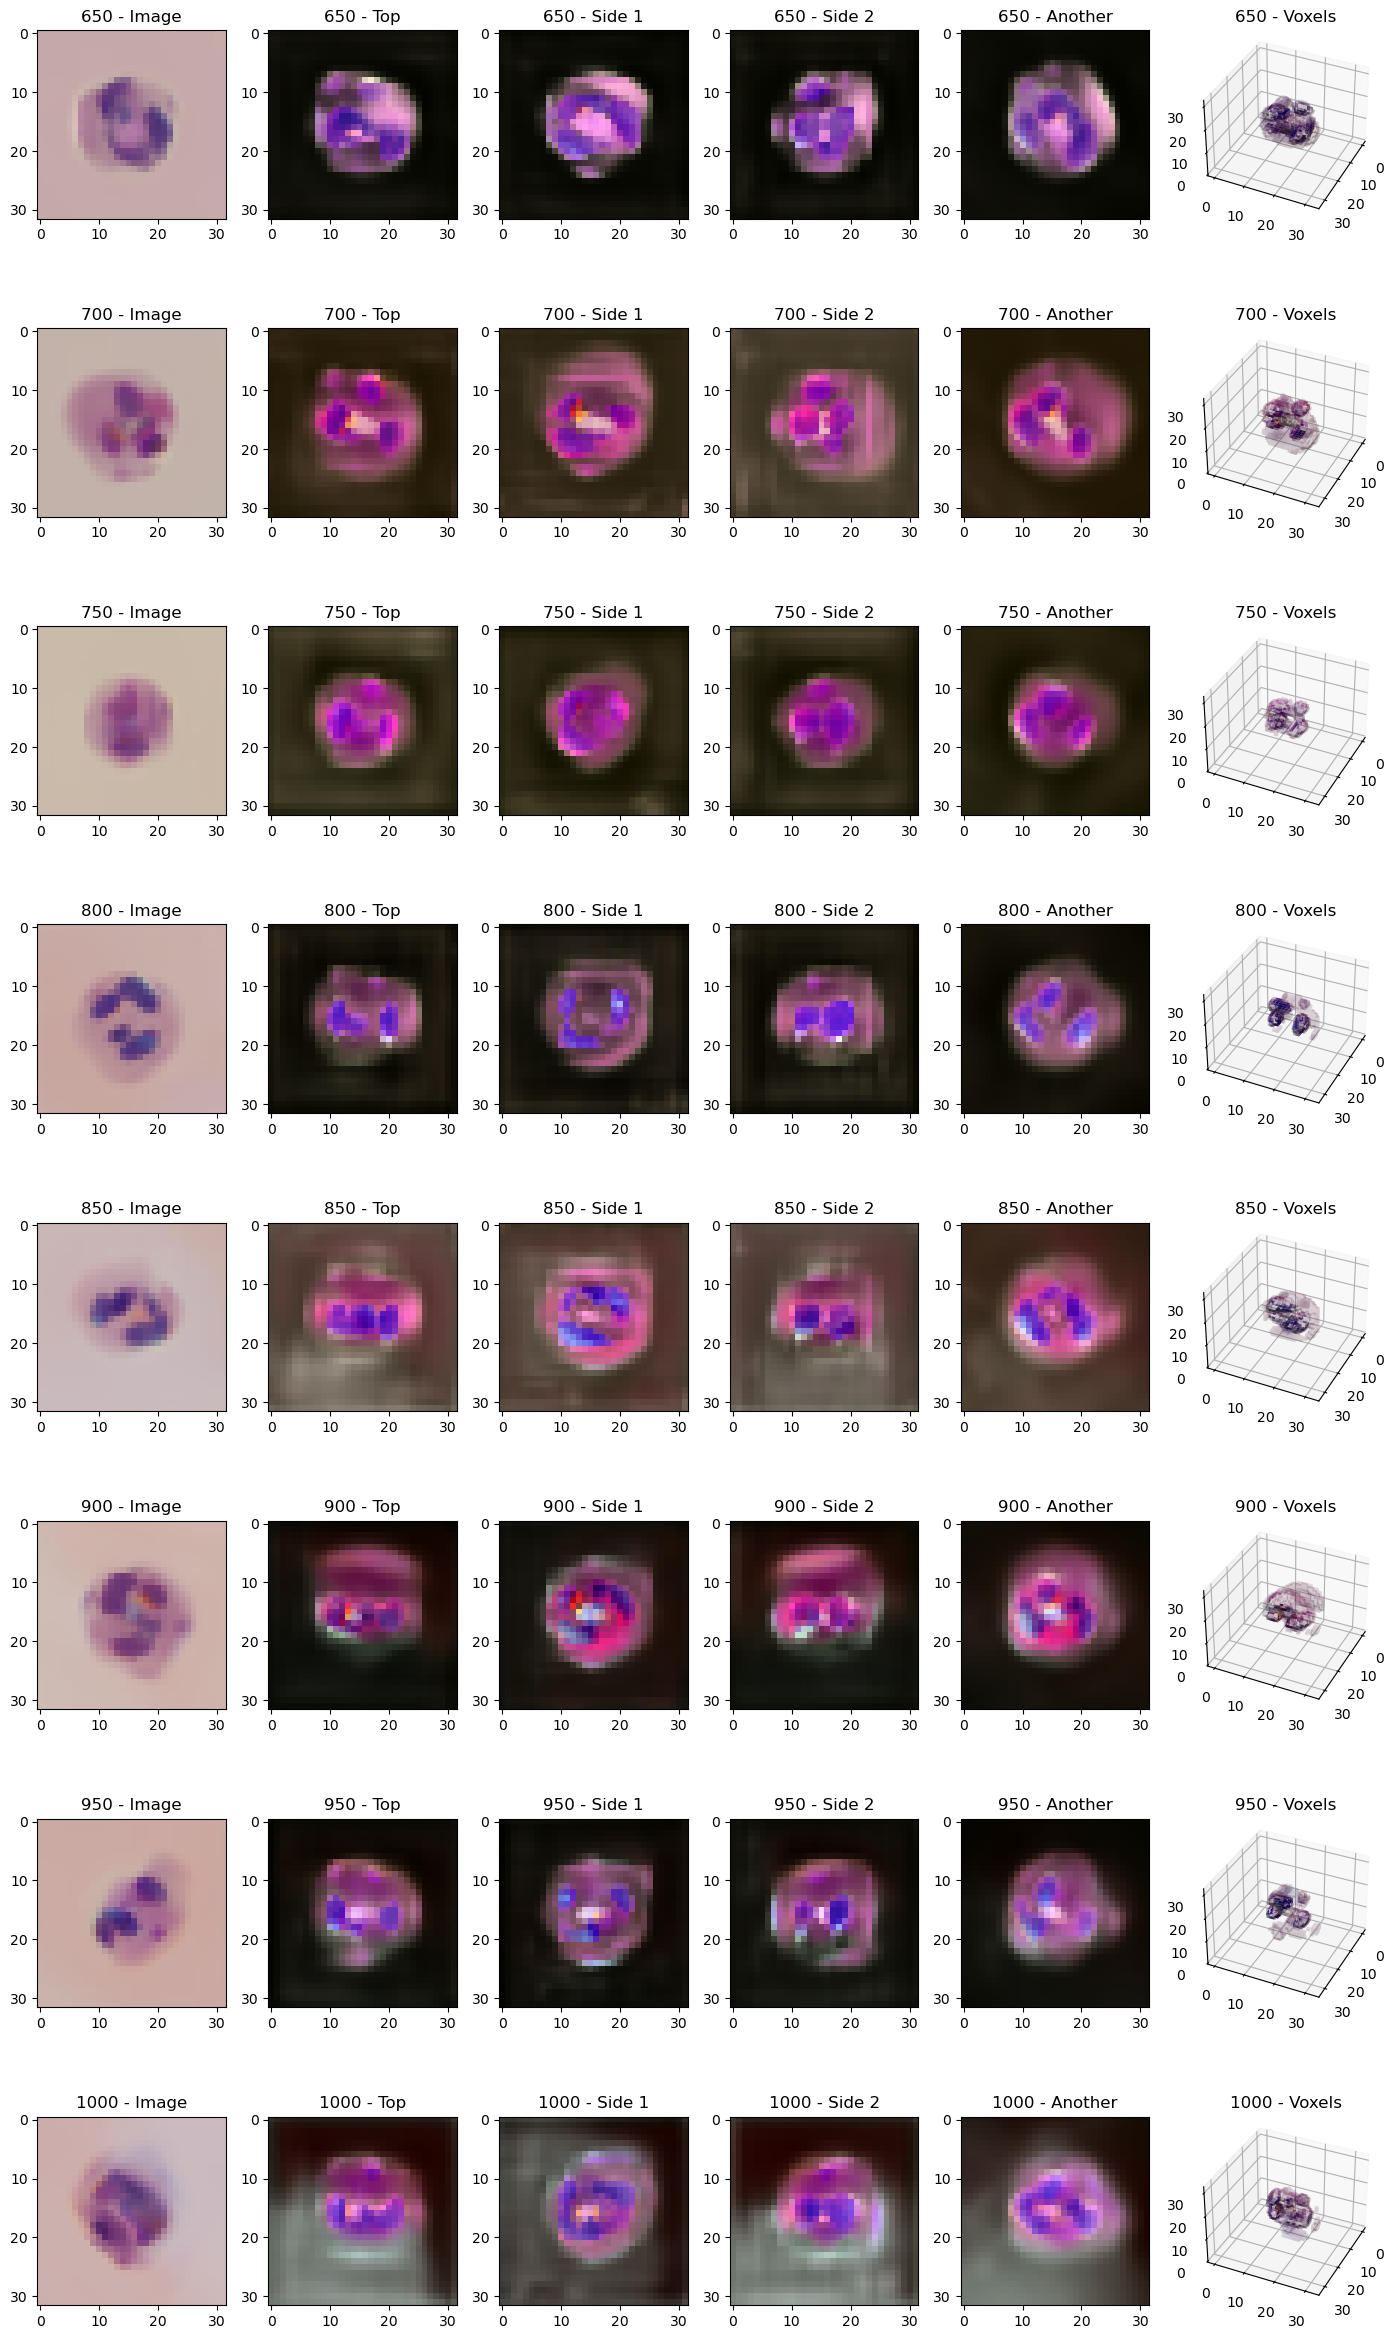

In [24]:
START_MODEL = 650
END_MODEL = 1000

models = list(range(START_MODEL, END_MODEL + 1, bookmark_interval))

mask_gen.eval()
mask_gen.to(DEVICE)

N_MODELS = (END_MODEL - START_MODEL) // bookmark_interval + 1

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for model_n in models:
    gan_trainer.load_state(f"{model_path}_{model_n}.pt")

    mask = metaimage.ColourImage(
        mask_gen(gen_input)[0], title=f"{model_n} - Image", normalize=False
    )
    voxels = voxgrid.VoxGrid(
        vox_gen(gen_input)[0], title=f"{model_n} - Voxels"
    )
    
    bg_out = mask_gen.background_gen(gen_input)[0]

    bg_out = bg_out.detach().cpu().numpy()
    
    bg_out = np.zeros((32, 32)) + bg_out[:3, :, :] * bg_out[-1, :, :]
    
    bg_out = np.moveaxis(bg_out, 0, -1)
    
    bg = metaimage.ColourImage(
        bg_out, title=f"{model_n} - Background", normalize=False
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            (f"{model_n} - Side 2", voxels.rotated(z_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(z_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(14, 3 * N_MODELS))
display.show()

Model models/neutro_gan_650.pt is loaded from epoch 650 , loss 1.3233


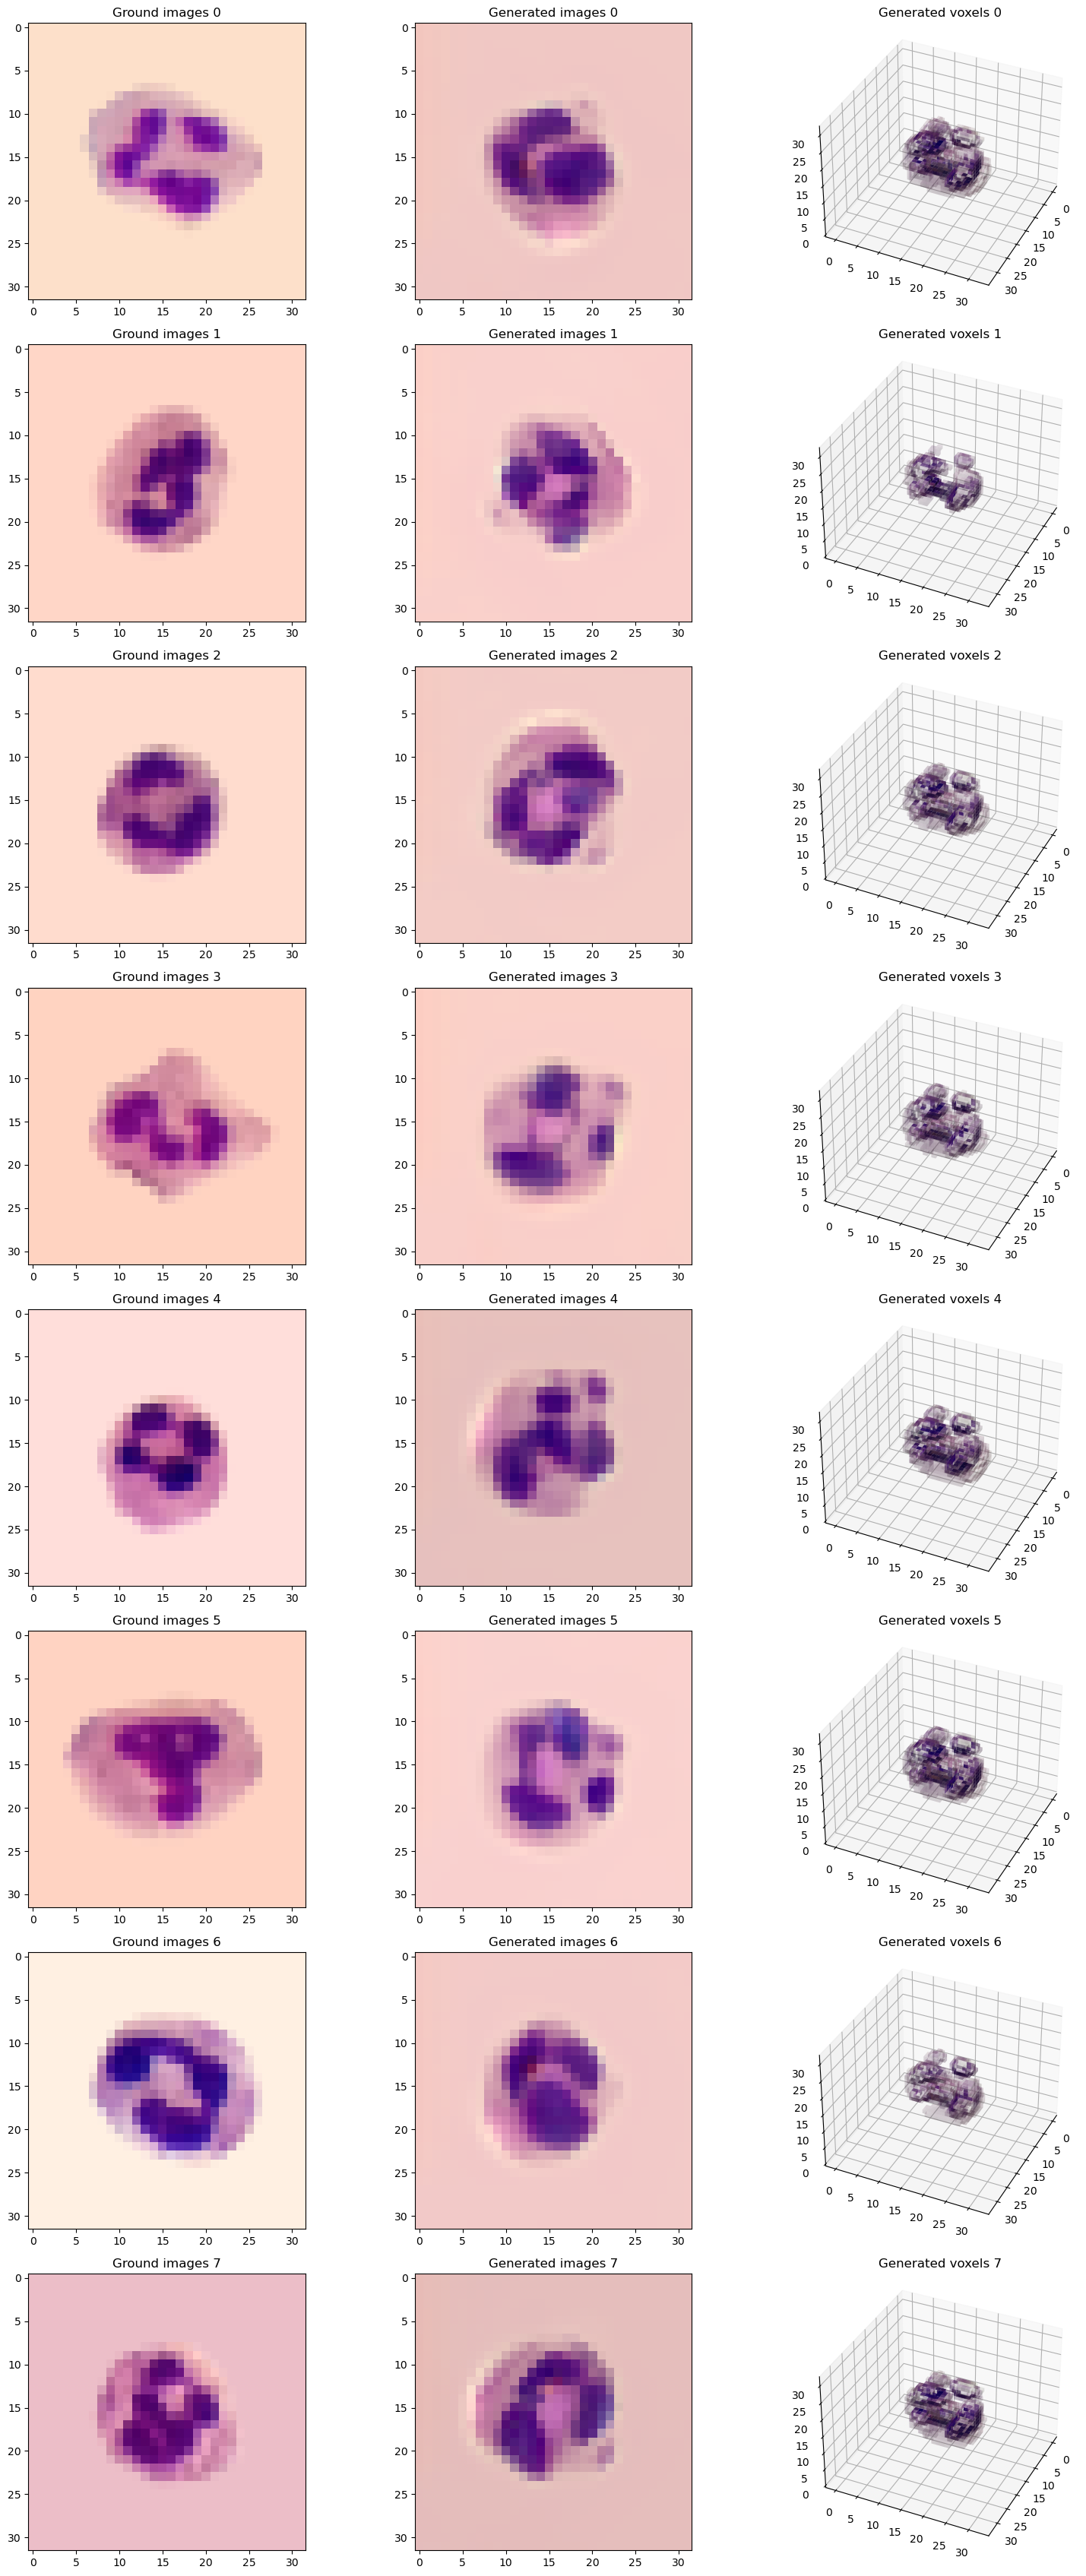

In [32]:
MODEL = 650

gan_trainer.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(8, LATENT_SIZE))).cuda()

masks = mask_gen(gen_input)[:8]
voxels = vox_gen(gen_input)[:8]

plot_grid = []

for i in range(8):
    cur_voxels = voxgrid.VoxGrid(voxels[i], title=f"Generated voxels {i}")
    rot_voxels = cur_voxels.rotated(x_angle=np.pi, y_angle=np.pi/2)
    cur_mask = metaimage.ColourImage(masks[i], title=f"Generated images {i}")
    ground_mask = train_auto_dataset[i][1]
    ground_mask = metaimage.ColourImage(ground_mask, title=f"Ground images {i}")

    plot_grid.append([ground_mask, cur_mask, cur_voxels])

display.grid(plot_grid, figsize=(16, 4.25*8))
display.show()